# Chapter 2. The two body problem
## Action by Jorge I. Zuluaga, University of Antioquia

In this notebook we will present part of the theoretical background of the chapter devoted to the *Two body problem* and some mathematical and numerical results which are interested for the theory.

For details on the theory please refer directly to the book:

> Murray, C. D., & Dermott, S. F. (1999). Solar system dynamics. Cambridge university press.

## Preliminaries

### Prerrequisites

Before running this notebook please install the following packages

In [4]:
!pip install --upgrade -q pip
!pip install -q pymcel
!pip install -q celluloid

### Tools from other libraries

In [296]:
import numpy as np
import rebound as rb
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import celluloid as cell
from IPython.core.display import HTML
from scipy.interpolate import interp1d
from scipy.integrate import quad
import sympy as sp
from astroquery.jplhorizons import Horizons

In [6]:
%matplotlib nbagg
#If you run this in Colab use
#%matplotlib inline

## Section 2.1

### Experiment: Jupiter perturbation (2.1)

Let's check that in fact Saturn is the main perturber of Jupiter. For this purpose we will use rebound to integrate the Solar System including the Sun, Jupiter and the other planets during 10 periods of Jupiter and will see what happen to one of its orbital elements.

Create the solar system with the sun and Jupiter:

In [52]:
sim=rb.Simulation()
sim.units=('au','msun','yr')
sim.add("Sun",hash="Sun")
sim.add("Jupiter",hash="Jupiter")
sim.save("tmp/system.bin")

Searching NASA Horizons for 'Sun'... 
Found: Sun (10) 
Searching NASA Horizons for 'Jupiter'... 
Found: Jupiter Barycenter (5) (chosen from query 'Jupiter')


Let's take and observation period:

In [54]:
Nt=100
ts=np.linspace(0,10*sim.particles["Jupiter"].P,Nt)

Now we will add each planet:

In [55]:
sistema_solar = ["Mercury", "Venus", "Earth", "Mars", "Saturn", "Uranus", "Neptune"]
Nplanets=len(sistema_solar)

To study the effect of the other planets we will integrate the orbit of Jupiter and the perturbing planet for the time and take which effect have the other planet on the osculating eccentricity:

In [57]:
es=np.zeros((Nplanets,Nt))
for n,obj in enumerate(sistema_solar):
    sim=rb.Simulation("tmp/system.bin")
    sim.add(obj,hash=obj)
    for i,t in enumerate(ts):
        sim.integrate(t)
        sim.move_to_com()
        orbits=sim.calculate_orbits()
        es[n,i]=orbits[0].e
    del sim

Searching NASA Horizons for 'Mercury'... 
Found: Mercury Barycenter (199) (chosen from query 'Mercury')
Searching NASA Horizons for 'Venus'... 
Found: Venus Barycenter (299) (chosen from query 'Venus')
Searching NASA Horizons for 'Earth'... 
Found: Earth-Moon Barycenter (3) (chosen from query 'Earth')
Searching NASA Horizons for 'Mars'... 
Found: Mars Barycenter (4) (chosen from query 'Mars')
Searching NASA Horizons for 'Saturn'... 
Found: Saturn Barycenter (6) (chosen from query 'Saturn')
Searching NASA Horizons for 'Uranus'... 
Found: Uranus Barycenter (7) (chosen from query 'Uranus')
Searching NASA Horizons for 'Neptune'... 
Found: Neptune Barycenter (8) (chosen from query 'Neptune')


<IPython.core.display.Javascript object>


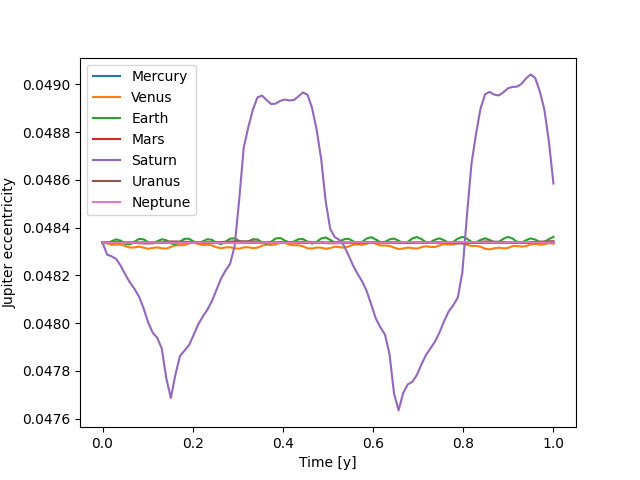

In [81]:
fig,ax=plt.subplots()
for n,obj in enumerate(sistema_solar):
    ax.plot(ts,es[n],label=f"{obj}")
    
#Decoration
ax.legend()
ax.set_xlabel(f"Time [y]")
ax.set_ylabel(f"Jupiter eccentricity")
fig.savefig(f"figures/jupiter-eccentricity.png")

## Section 2.2. Equations of motion

### Experiment: integrating polar equations of motion (2.2) 

The following are the polar equations of motion of the two body problem (see Eqs. 2.8 and 2.11):
$$
\begin{aligned}
\ddot{r}-h^2/r^3 & =-\frac{\mu}{r^2}\\
\dot{\theta} & =  \frac{h}{r^2}
\end{aligned}
$$
where $\vec h \equiv \vec r \times \dot{\vec{r}}$ is a constant of motion.  And the vectors $\vec r = r\hat{\mathbf{r}}$ and $\dot{\mathbf{r}}=\dot{r} \hat{\mathbf{r}}+r \dot{\theta} \hat{\boldsymbol{\theta}}$

Can we integrate these equations of motion instead of integrating the cartesian equations ones?

First we need to express them as a system of first-order differential equations. Using the auxiliar variable $v=\dot r$, they are:

$$
\begin{aligned}
\dot{r}& =v \\
\dot{v}& =-\frac{\mu}{r^2}+\frac{h^2}{r^3} \\
\dot{\theta} & = \frac{h}{r^2}
\end{aligned}
$$

The numerical version of the equations will be:

In [243]:
def edm_polar(Y,t,mu=1,h=1):
    r,v,theta=Y
    
    dr_dt=v
    dv_dt=-mu/r**2+h**2/r**3
    dtheta_dt=h/r**2
    
    return [dr_dt,dv_dt,dtheta_dt]

Let's integrate them

In [244]:
#Properties of the system
mu=1

#Initial conditions
r=1
v=0.2
theta=0

Ys=[r,v,theta]

#Using the initial conditions we need to compute h
h=np.sqrt((v+mu/r**2)*r**3)
print(f"Specific angular momentum: {h}")

#Integration time
Nt=1000
ts=np.linspace(0,50,Nt)

#Solution
solution=odeint(edm_polar,Ys,ts,args=(mu,h))
rs=solution[:,0]
thetas=solution[:,2]

Specific angular momentum: 1.0954451150103321


Now we can see the solution in polar coordinates:

<IPython.core.display.Javascript object>


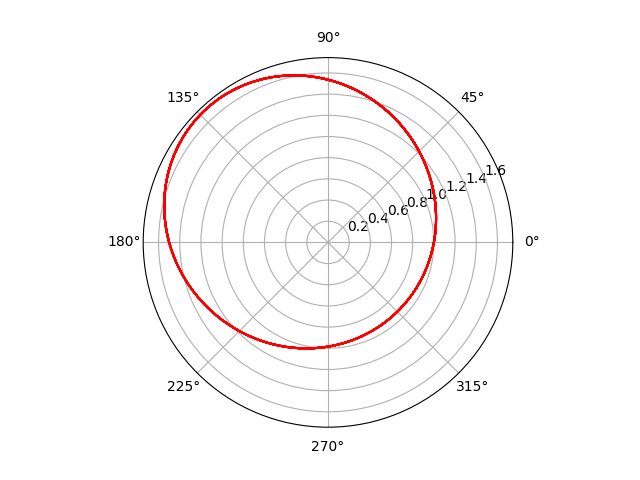

In [245]:
fig,ax=plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(thetas,rs,'r-')

### Experiment: orbital motion animation (2.2)

Let's animate the motion using `celluloid`.

For this purpose we need to plot what we want to animate and capture a snapshot at each time.

In [246]:
plt.ioff()
fig,ax=plt.subplots(subplot_kw={'projection': 'polar'})
camera=cell.Camera(fig)

n=int(Nt/100)
for theta,r in zip(thetas[::n],rs[::n]):
    ax.plot(theta,r,'ro')
    camera.snap()
    
plt.close()
plt.ion();

Now it's time to create the animation:

In [247]:
anim=camera.animate(interval=100)
anim.save("figures/orbit-animation.mp4")

Show the animation:

In [237]:
HTML(anim.to_html5_video())

### Experiment: areas law (2.1)

The Kepler's second law is very well known and related to the fact that when a object pass through the periapsis the velocity is larger. But, what about the area. In this experiment we will check the area law, by measuring the approximate areal velocity in the orbit.

In polar coordinates the area of a figure is given by:

$$
A = \frac{1}{2}\int_{\theta_i}^{\theta_f} r^2(\theta)\;\mathrm{d}\theta
$$

If we interpolate:

In [238]:
fun_theta=interp1d(ts,thetas)
fun_r=interp1d(thetas,rs)

Now we want to integrate `fun_r` between two times:

In [242]:
#Interval
i=0
f=i+5

#Times
ti=ts[i]
tf=ts[f]
dt=tf-ti

#Angles
theta_i=fun_theta(ti)
theta_f=fun_theta(tf)

#Sweept area
integrand=lambda theta:fun_r(theta)**2
integral,error=quad(integrand,theta_i,theta_f)
dA=integral/2

#Areal velocity
dAdt=dA/dt
print(f"Areal velocity: {dA/dt}")
print(f"Expected value: {h/2}")

Areal velocity: 0.547779747250149
Expected value: 0.5477225575051661


## Section 2.3. Orbital position and velocity

### Experiment: solution to the shape equation (2.3)

Let's use `sympy` to solve the shape equation (Eq. 2.13):

$$
\frac{\mathrm{d}^2 u}{\mathrm{~d} \theta^2}+u=\frac{\mu}{h^2}
$$

In [275]:
q,mu,h=sp.symbols("theta mu h")
u=sp.Function("u")
dudq=sp.diff(u(q),q)
shape_equation=sp.diff(u(q),q,q)+u(q)-mu/h**2
sp.dsolve(shape_equation,u(q))

Eq(u(theta), C1*sin(theta) + C2*cos(theta) + mu/h**2)

If we now put initial conditions: $u(0) = 1$, $du/d\theta = 0$: 

In [283]:
sp.expand(sp.dsolve(shape_equation,u(q),ics={u(0):1,u(q).diff(q).subs(q,0):0}))

Eq(u(theta), cos(theta) - mu*cos(theta)/h**2 + mu/h**2)

### Experiment: Kepler's law in moon systems (2.3)

Let's calculate the mass of Jupiter using the Kepler's third law:

For this purpose we need the mass of the sun:

In [310]:
from astropy import constants as c
M_sun=c.M_sun
M_sun

<<class 'astropy.constants.iau2015.IAU2015'> name='Solar mass' value=1.988409870698051e+30 uncertainty=4.468805426856864e+25 unit='kg' reference='IAU 2015 Resolution B 3 + CODATA 2018'>

Now we need at a given the semimajor axis and period of Jupiter with respect to the Sun:

In [326]:
from astropy.time import Time
epoch=Time("2023-01-01 00:00:00",format="iso").jd
jupiter=Horizons(id="599",location="@Sun").elements().to_pandas()

a_planet=jupiter.a[0]
P_planet=jupiter.P[0]

Now compute the same quantity for a given moon:

In [327]:
io=Horizons(id="501",location="@5").elements().to_pandas()

The mass of the planet can be estimated using (Eq. 2.24):

$$
\frac{m}{m_{\mathrm{c}}}=\left(\frac{a^{\prime}}{a}\right)^3\left(\frac{T}{T^{\prime}}\right)^2
$$
where $m$ and $m_{\mathrm{c}}$ are the mass of the planet and the star, respectively, and the prime quantities correspond to properties of the moon, while the non-primed quantities are properties of the planet.

In [328]:
M_planet=M_sun*(io.a[0]/a_planet)**3*(P_planet/io.P[0])**2
M_planet

<Quantity 1.89643942e+27 kg>

One way to express the previous equation is expressing this equation as:

$$
\left(\frac{T}{T^{\prime}}\right)=\left(\frac{m}{m_{\mathrm{c}}}\right)^{1/2}\left(\frac{a}{a^{\prime}}\right)^{3/2}
$$

Taking the logarithm:

$$
\log\left(\frac{T}{T^{\prime}}\right)=\frac{1}{2}\log\left(\frac{m}{m_{\mathrm{c}}}\right)+\frac{3}{2}\log\left(\frac{a}{a^{\prime}}\right)
$$


So, if we make a plot of $\log(T/T')$ vs. $\log(a/a')$ the slope should be close to $3/2$ and the intercept will give us the mass of the planet. Let's check it with Jupiter.

First we need the data about the moons:

In [382]:
a_moons=[]
P_moons=[]
for imoon in range(1,15):
    moon=Horizons(id=str(500+imoon),location="@5",epochs=epoch).elements().to_pandas()
    a_moons+=[moon.a]
    P_moons+=[moon.P]
    
a_moons=np.array(a_moons)
P_moons=np.array(P_moons)

Now plot the points:

<IPython.core.display.Javascript object>


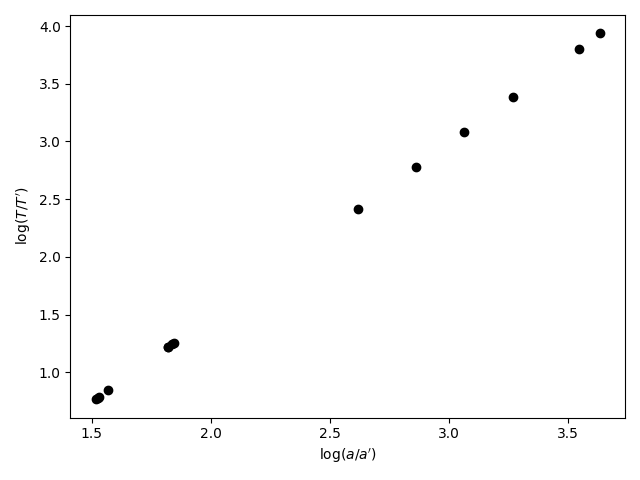

In [383]:
fig,ax=plt.subplots()

ax.plot(np.log10(a_planet/a_moons),np.log10(P_planet/P_moons),'ko')

#Decoration
ax.set_xlabel(r"$\log(a/a')$")
ax.set_ylabel(r"$\log(T/T')$")

fig.tight_layout()

Now let's perform a linear regresion on the data:

In [384]:
from sklearn.linear_model import LinearRegression

xs=np.log10(a_planet/a_moons).reshape((-1,1))
ys=np.log10(P_planet/P_moons)

model=LinearRegression().fit(xs, ys)

#Coefficients
m=model.coef_[0]
b=model.intercept_

print(f"Slope: {m}")
print(f"Intercept: {b}")

Slope: [1.49999055]
Intercept: [-1.51024056]


We can compare the values predicted and calculated from the theoretical model:

<IPython.core.display.Javascript object>


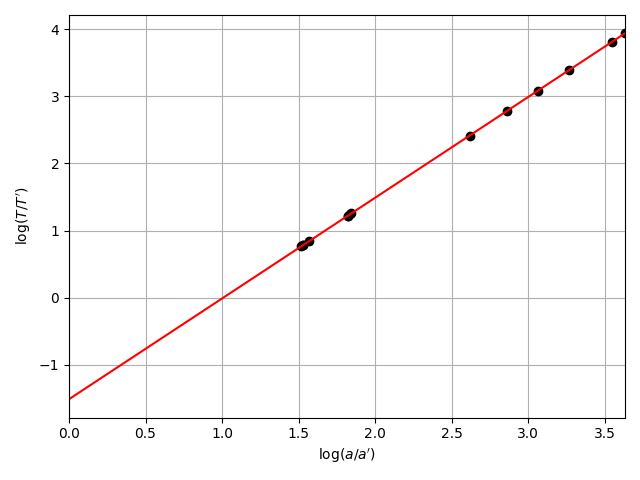

In [392]:
fig,ax=plt.subplots()

#Expected
xes=np.linspace(0,xs.max()).reshape((-1,1))
yes=model.predict(xes)

#Observed
ax.plot(xs,ys,'ko')
ax.plot(xes,yes,'r-')

#Adjust
ax.set_xlim(0,xs.max())

#Decoration
ax.set_xlabel(r"$\log(a/a')$")
ax.set_ylabel(r"$\log(T/T')$")
ax.grid()

fig.tight_layout()

Now we can calculate the mass of the planet:

In [385]:
M_planet=10**(2*b)*M_sun
M_planet

<Quantity [1.89681421e+27] kg>

## Section 2.4 The Mean and Eccentric Anomalies

### Experiment: eccentricity series for the eccentric anomaly (2.4)

We want to develop the expansions leading to equations (2.55) using `SymPy`.

For this purpose we define the basic variables:

In [484]:
e,M=sp.symbols("e M")

Now we express the first step to the fixed-point procedure

In [485]:
E1=M+e*sp.sin(M)
E1

M + e*sin(M)

The second step will be

In [486]:
E2_full=M+e*sp.sin(E1)
E2_full

M + e*sin(M + e*sin(M))

Expanding the trigonometrical functions:

In [493]:
E2_exp=E2_full.expand(trig=True)
E2_exp

M + e*sin(M)*cos(e*sin(M)) + e*sin(e*sin(M))*cos(M)

Now we can expand in series of $\sin(M)$:

In [501]:
E2=sp.simplify(E2_full.series(sp.sin(M),n=3).removeO())
E2

M + e**2*sin(2*M)/2 + e*sin(M)

If we repeat the procedure:

In [508]:
E3_full=M+e*sp.sin(E2)
E3=sp.simplify(E3_full.expand(trig=True).series(e,n=4).removeO())
E3

M + e**3*(2 - 3*sin(M)**2)*sin(M)/2 + e**2*sin(2*M)/2 + e*sin(M)

In [510]:
E4_full=M+e*sp.sin(E3)
E4=sp.simplify(E4_full.expand(trig=True).series(e,n=5).removeO())
E4

M + e**4*(-sin(2*M)/2 + sin(4*M))/3 + e**3*(2 - 3*sin(M)**2)*sin(M)/2 + e**2*sin(2*M)/2 + e*sin(M)

### Experiment: testing the Danby method for Kepler's equation (2.4)

We want to test the convergence speed of the Danby's method.

The method is based in the expansion (Eq. 2.59):

$$
0=f\left(E_i+\delta_i\right)=f\left(E_i\right)+\delta_i f^{\prime}\left(E_i\right)+\frac{1}{2} \delta_i^2 f^{\prime \prime}\left(E_i\right)+\frac{1}{6} \delta_i^3 f^{\prime \prime \prime}\left(E_i\right)+\mathcal{O}\left(\delta_i^4\right)
$$

We can obtain from this equation the $\delta_i$ in a recursive fashion as:

$$
\delta_{i 1}=-\frac{f_i}{f_i^{\prime}}, \quad \delta_{i 2}=-\frac{f_i}{f_i^{\prime}+\frac{1}{2} \delta_{i 1} f_i^{\prime \prime}}, \quad \delta_{i 3}=-\frac{f_i}{f_i^{\prime}+\frac{1}{2} \delta_{i 2} f_i^{\prime \prime}+\frac{1}{6} \delta_{i 2}^2 f_i^{\prime \prime \prime}}
$$

where 

$$
f(E)=E-e\sin E-M
$$
and $f_i\equiv f(E_i)$.

The derivatives of the function are:

$$
f'(E)=1-e\cos E\\
f''(E)=e\sin E\\
f'''(E)=e\cos E
$$

Let's create a routine:

In [530]:
def newton_danby(M,e,E0,abstol=1e-5):
    Ei=2*E0
    one_six=1/6
    i=0
    while abs(Ei-E0)>abstol:
        #Basic values
        e_sinEi=e*np.sin(Ei)
        e_cosEi=e*np.cos(Ei)
        #Function and derivatives
        fi=Ei-e_sinEi-M
        fpi=1-e_cosEi
        fppi=e_sinEi
        fpppi=e_cosEi
        #Deltas
        delta1i=-fi/fpi
        delta2i=-fi/(fpi+0.5*delta1i*fppi)
        delta3i=-fi/(fpi+0.5*delta2i*fppi+one_six*delta2i**2*fppi)
        #Step
        E0=Ei
        Ei=Ei+delta3i
        i+=1
    return Ei,abs(Ei-E0),i

Let's compare it with the Newton Method:

In [536]:
from pymcel import kepler_newton
e=0.5
M=np.pi/2.3
kepler_newton(M,e,M,delta=1e-14)

(1.8469636313928361, 2.404428556696404e-15, 5)

Compared with the Danby method:

In [537]:
newton_danby(M,e,M,abstol=1e-14)

(1.846963631392834, 2.220446049250313e-16, 4)

The Danby method converges in just 4 steps.  Now time the methods:

In [538]:
%timeit kepler_newton(M,e,M,delta=1e-14)

23.6 µs ± 78.5 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [539]:
%timeit newton_danby(M,e,M,abstol=1e-14)

15.3 µs ± 38.3 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


Although the Danby method has more function evaluations it takes almost half of the time than the traditional Newton's method.

And if we use the initial value suggested by Danby:

In [546]:
k=0.85
E0=M+np.sign(np.sin(M))*k*e
print(M,E0)
newton_danby(M,e,E0,abstol=1e-14)

1.3659098493868667 1.7909098493868667


(1.846963631392834, 0.0, 5)

It takes a step further but the final error is zero. Now, the running time:

In [547]:
%timeit newton_danby(M,e,E0,abstol=1e-14)

20 µs ± 120 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Which is larger than using $M$ as guess value, but still lower than with the regular N-R formula.

### Other ideas for this section

- Deriving functions $f$ and $g$

## Section 2.5 Elliptic Expansions

### Other ideas for this section

- These are the ideas

## Section 2.6 The Guiding Centre Approximation

### Other ideas for this section

- These are the ideas

## Section 2.7 Barycentric Orbits

### Other ideas for this section

- These are the ideas

## Section 2.8 The Orbit in Space

### Other ideas for this section

- These are the ideas

## Section 2.9 Perturbed Orbits

### Other ideas for this section

- These are the ideas

## Section 2.10 Hamiltonian Formulation

### Other ideas for this section

- These are the ideas

## References

- Linear regression with `scikit-learn` https://realpython.com/linear-regression-in-python/